In [8]:
import os
import pandas as pd
from pathlib import Path

columns_ds = ["StartTime", "Dur", "Proto", "SrcAddr", "DstAddr", "State", "TotPkts", "TotBytes", "SrcBytes", "Label"]

def load_datasets(directory: str, columns_ds: list[str]) -> pd.DataFrame:
    datasets = []

    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".binetflow"):
                datasets.append(Path(root) / file)
                break

    df = pd.concat(
        [pd.read_csv(f, usecols=columns_ds) for f in datasets],
        ignore_index=True
    )

    df = df[df['Proto'].isin(["tcp", "udp", "icmp"])]
    df = df[df['State'].isin(["FSPA_FSPA", "URP", "CON"])]

    return df

input_directory = "datasets/CTU-13-Dataset/"
output_file = Path("datasets/all-data-filtered.csv.gz")

if not output_file.is_file():
    print("Filtered dataset not found. Generating it now...")
    df = load_datasets(input_directory, columns_ds)
    df.to_csv(output_file, index=False, compression='gzip', sep='\t')
    del df
else:
    print("The dataset has already been created.")

# Load sample for analysis
total_rows_to_read = 1_000_000
df = pd.read_csv(output_file, usecols=columns_ds, compression='gzip', sep='\t', nrows=total_rows_to_read)
print(f"Loaded {len(df)} rows.")


The dataset has already been created.
Loaded 1000000 rows.


In [9]:
display(df)

,StartTime,Dur,Proto,SrcAddr,DstAddr,State,TotPkts,TotBytes,SrcBytes,Label
0,2011/08/10 09:46:53.047277,3550.182373,udp,212.50.71.179,147.32.84.229,CON,12,875,413,flow=Background-UDP-Established
1,2011/08/10 09:46:53.048843,0.000883,udp,84.13.246.132,147.32.84.229,CON,2,135,75,flow=Background-UDP-Established
2,2011/08/10 09:46:53.053937,3427.768066,udp,74.89.223.204,147.32.84.229,CON,42,2856,1596,flow=Background-UDP-Established
3,2011/08/10 09:46:53.058746,3589.631348,udp,182.239.167.121,147.32.84.229,CON,12,1494,1122,flow=Background-UDP-Established
4,2011/08/10 09:46:53.062095,3118.470947,udp,24.117.206.20,147.32.84.229,CON,13,4328,840,flow=Background-UDP-Established
...,...,...,...,...,...,...,...,...,...,...
999995,2011/08/10 12:18:21.527939,0.001147,udp,85.239.154.123,147.32.84.229,CON,2,585,81,flow=Background-UDP-Established
999996,2011/08/10 12:18:21.565356,0.000875,udp,1.72.3.161,147.32.84.229,CON,2,571,89,flow=Background-UDP-Established
999997,2011/08/10 12:18:21.569022,2.944883,udp,204.112.17.92,147.32.84.229,CON,4,651,531,flow=Background-UDP-Established
999998,2011/08/10 12:18:21.569255,1248.551392,udp,80.92.246.112,147.32.84.229,CON,6,771,550,flow=Background-UDP-Established


In [11]:
from datetime import datetime
import networkx as nx
import pandas as pd
from pathlib import Path
import pickle  # For saving and loading the graph

def load_graph(df):
    G = nx.Graph()
    string_index = {}

    def get_index_node(text):
        if text not in string_index:
            string_index[text] = len(string_index) + 1
        return string_index[text]
    
    protocol_enabled = {"tcp": 0, "udp": 1, "icmp": 2}
    state_enabled = {"fspa_fspa": [1, 0, 0], "urp": [0, 1, 0], "con": [0, 0, 1]}

    def check_protocol(protocol):
        return protocol_enabled[protocol.lower()]

    def check_state(state):
        return state_enabled[state.lower()]

    for _, row in df.iterrows():
        source, destination = row['SrcAddr'], row['DstAddr']
        start_time = datetime.strptime(row['StartTime'], "%Y/%m/%d %H:%M:%S.%f")
        protocol = row['Proto']
        duration = row['Dur']
        totalbytes = row['TotBytes']
        totalpackets = row['TotPkts']
        state = row['State']

        protocol = check_protocol(protocol)
        state = check_state(state)

        src_index = get_index_node(source)
        dst_index = get_index_node(destination)

        if not G.has_node(src_index):
            G.add_node(src_index, host=source)

        if not G.has_node(dst_index):
            G.add_node(dst_index, host=destination)

        label = 1 if "Botnet" in row['Label'] else 0

        if G.has_edge(src_index, dst_index):
            edge = G[src_index][dst_index]
            edge['flow_network'].append([
                protocol, duration, totalbytes, totalpackets,
                (start_time - edge['periodicity']).total_seconds(),
                label
            ] + state)
        else:
            G.add_edge(src_index, dst_index)
            G[src_index][dst_index]['flow_network'] = [[
                protocol, duration, totalbytes, totalpackets,
                0.0, label
            ] + state]
            G[src_index][dst_index]['periodicity'] = start_time

    return G

# Path to save the graph model
path_graph_model = "model/graph_model.pickle"
graph_file = Path(path_graph_model)

if not graph_file.is_file():
    G = load_graph(df)
    with open(path_graph_model, "wb") as f:
        pickle.dump(G, f)
else:
    with open(path_graph_model, "rb") as f:
        G = pickle.load(f)


In [12]:
import numpy as np

def statistic_summary(data):
    return [np.mean(data), np.std(data), np.median(data), max(data), min(data)]

def create_model(G):
    X = []
    y = []
    total_edges = 0
    irrelevant_total_traffic = 3

    for u, v, traffic in G.edges.data('flow_network'):
        if len(traffic) <= irrelevant_total_traffic:
            continue

        label = [v[5] for v in traffic][0] 
        total_edges += 1

        features = []
        duration = total_bytes = total_packets = periodicity = []
        for v in traffic:
            duration.append(v[1])
            total_bytes.append(v[2])
            total_packets.append(v[3])
            periodicity.append(v[4])

        repeated_count = [len(traffic)]
        features += statistic_summary(duration)
        features += statistic_summary(total_bytes)
        features += statistic_summary(total_packets)
        features += statistic_summary(periodicity)
        features += repeated_count
        
        X.append(features)
        y.append(label)

    # Convert to numpy arrays
    X = np.array(X).reshape(total_edges, 21, 1)
    y = np.array(y).reshape((-1, 1))
    return X, y

X, y = create_model(G)


C:\Users\Sumukha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 19, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 9, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,169 (90.50 KB)

 Trainable params: 23,169 (90.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9790 - loss: 0.0791 - val_accuracy: 0.9982 - val_loss: 0.0138
Epoch 2/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.9979 - loss: 0.0156 - val_accuracy: 0.9982 - val_loss: 0.0137
Epoch 3/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9985 - loss: 0.0118 - val_accuracy: 0.9982 - val_loss: 0.0133
Epoch 4/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9986 - loss: 0.0108 - val_accuracy: 0.9982 - val_loss: 0.0135
Epoch 5/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9983 - loss: 0.0131 - val_accuracy: 0.9982 - val_loss: 0.0135
Epoch 6/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9983 - loss: 0.0130 - val_accuracy: 0.9982 - val_loss: 0.0135
Epoch 7/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9983 - loss: 0.0128 - val_accuracy: 0.9982 - val_loss: 0.0135
Epoch 8/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9977 - loss: 0.0164 - val_

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 19, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 9, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,169 (90.50 KB)

 Trainable params: 23,169 (90.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.9912 - loss: 0.0578 - val_accuracy: 0.9982 - val_loss: 0.0134
Epoch 2/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9984 - loss: 0.0121 - val_accuracy: 0.9982 - val_loss: 0.0135
Epoch 3/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9987 - loss: 0.0102 - val_accuracy: 0.9982 - val_loss: 0.0135
Epoch 4/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9979 - loss: 0.0158 - val_accuracy: 0.9982 - val_loss: 0.0134
Epoch 5/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9971 - loss: 0.0205 - val_accuracy: 0.9982 - val_loss: 0.0136
Epoch 6/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.9985 - loss: 0.0117 - val_accuracy: 0.9982 - val_loss: 0.0137
Epoch 7/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9976 - loss: 0.0173 - val_accuracy: 0.9982 - val_loss: 0.0137
Epoch 8/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9983 - loss: 0.0129 - val_acc

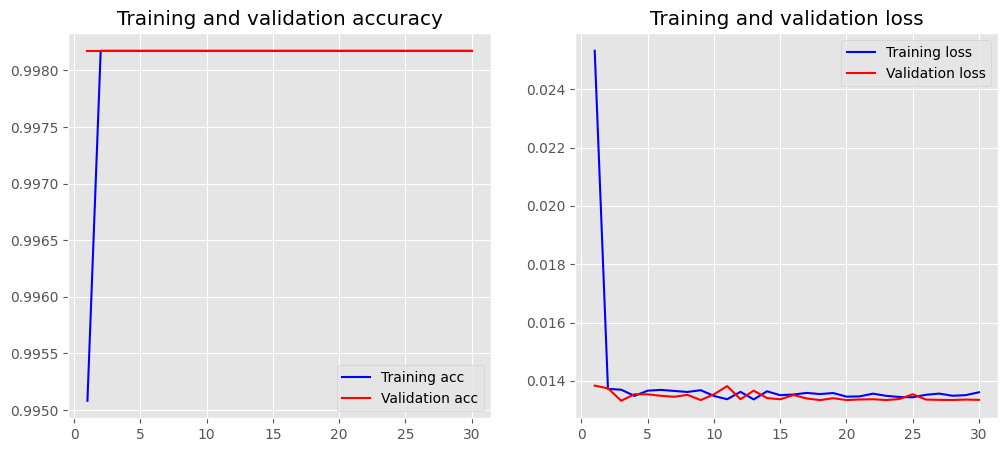

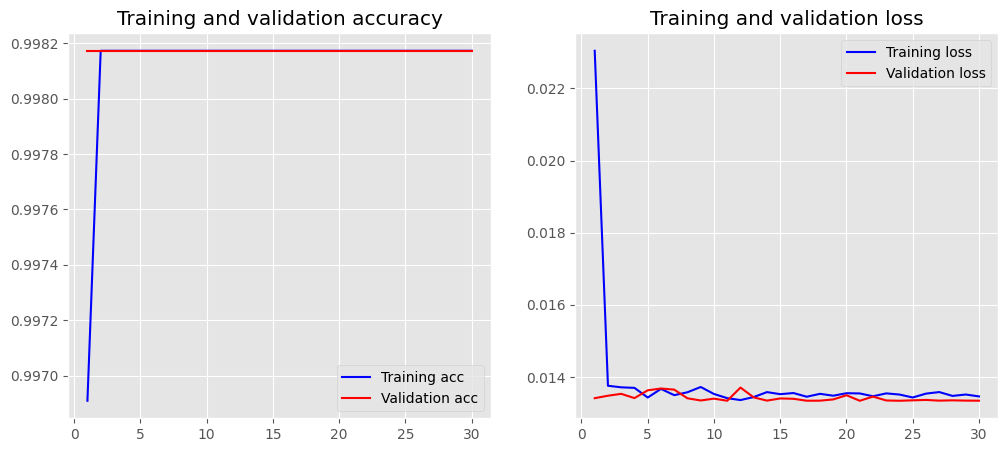

In [13]:
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras import layers
from keras import models
from keras import regularizers
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    return plt
    
kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)

plots = []
for train, test in kfold.split(X, y):
    model = Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu',input_shape=(X[train].shape[1], 1)))
    model.add(layers.MaxPool1D())
    model.add(layers.LSTM(units=32, dropout=0.1, recurrent_dropout=0.1))
    model.add(layers.Dense(64, activation = 'tanh',))
    model.add(layers.Dense(64, activation = 'tanh',))
    model.add(layers.Dense(64, activation = 'tanh',))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model.summary()

    history = model.fit(X[train], y[train],
                        epochs=30,
                        verbose=True,
                        validation_data=(X[test], y[test]),
                        shuffle=True,
                        batch_size=32)
    
    loss, accuracy = model.evaluate(X[train], y[train], verbose=False)
    print("Training Accuracy: {:.2f}".format(accuracy))
    loss, accuracy = model.evaluate(X[test], y[test], verbose=False)
    print("Testing Accuracy:  {:.4f}".format(accuracy))
    plots.append(plot_history(history))
    
for plt in plots:
    plt.show()

In [15]:
model.save('saved_models/lstm.keras')
